# Traffic Light Controller for a Single 4-Way Road Intersection using Deep Q-Network (DQN)

## Installations

We use SUMO (Simulation of Urban MObility) for simulating the traffic environment

In [1]:
!sudo apt-get install -y sumo sumo-tools sumo-doc
!pip install sumolib traci
!pip install torchviz




The following additional packages will be installed:
  binfmt-support fastjar fonts-roboto-unhinted gdal-data jarwrapper
  javascript-common libarmadillo9 libarpack2 libcfitsio8 libcharls2 libdap25
  libdapclient6v5 libepsilon1 libfox-1.6-0 libfreexl1 libfyba0 libgdal26
  libgeos-3.8.0 libgeos-c1v5 libgeotiff5 libglu1-mesa libhdf4-0-alt
  libjs-jquery libjs-openlayers libjs-underscore libkmlbase1 libkmldom1
  libkmlengine1 libminizip1 libmysqlclient21 libnetcdf15 libodbc1 libogdi4.1
  libpoppler97 libpq5 libproj15 libqhull7 libspatialite7 libsuperlu5
  liburiparser1 libxerces-c3.2 mysql-common odbcinst odbcinst1debian2
  poppler-data proj-bin proj-data
Suggested packages:
  apache2 | lighttpd | httpd geotiff-bin gdal-bin libgeotiff-epsg libhdf4-doc
  libhdf4-alt-dev hdf4-tools libmyodbc odbc-postgresql tdsodbc unixodbc-bin
  ogdi-bin poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-

In [2]:
!whereis sumo-gui

sumo-gui: /usr/bin/sumo-gui


In [3]:
# Confirming presence of sumocfg file
!ls /usr/share/sumo/tools/game/cross_demo.sumocfg

/usr/share/sumo/tools/game/cross_demo.sumocfg


In [4]:
# Confirming presence of the network file for cross_demo.sumocfg
!ls /usr/share/sumo/tools/game/cross/cross.net.xml

/usr/share/sumo/tools/game/cross/cross.net.xml


## Imports

In [5]:
import traci
import sumolib
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot

## Calculating frame dimensions

In [6]:
# Load the network file
net_file = "/usr/share/sumo/tools/game/cross/cross.net.xml"
net = sumolib.net.readNet(net_file)

# Get the network's boundaries
bounding_box = net.getBoundary()

# Calculate the width and height of the area
width = bounding_box[2] - bounding_box[0]
height = bounding_box[3] - bounding_box[1]

AREA_SIZE = (width, height)  # Width and height of the area in meters

print("AREA_SIZE:", AREA_SIZE)


AREA_SIZE: (400.0, 400.0)


## Utility functions

In [7]:
GRID_SIZE = (int(AREA_SIZE[0]), int(AREA_SIZE[1]))  # Rows and columns in the grid 
GRID_RES = (AREA_SIZE[0] / GRID_SIZE[0], AREA_SIZE[1] / GRID_SIZE[1])    

def get_next_phase(current_phase): # Note: This is specific to cross_demo.sumocfg 
    next_phase = {}
    for key in current_phase.keys():
        next_phase[key] = (current_phase[key] + 1)%12
    return next_phase

# Define a function to extract the current state from the simulation
def get_current_state():
    lanes = traci.lane.getIDList()
    queue_length = {lane: traci.lane.getLastStepHaltingNumber(lane) for lane in lanes}
    vehicle_count = {lane: traci.lane.getLastStepVehicleNumber(lane) for lane in lanes}
    avg_waiting_time = {lane: traci.lane.getWaitingTime(lane) for lane in lanes}
    traffic_light_ids = traci.trafficlight.getIDList()
    current_phase = {tl: traci.trafficlight.getPhase(tl) for tl in traffic_light_ids}
    next_phase = get_next_phase(current_phase)

    # Initialize the grid with zeros
    vehicle_grid = np.zeros((GRID_SIZE[1], GRID_SIZE[0]))

    # Get all vehicle IDs
    vehicle_ids = traci.vehicle.getIDList()

    # Loop through all vehicles and place them on the grid
    for veh_id in vehicle_ids:
        # Get the position of the vehicle
        x, y = traci.vehicle.getPosition(veh_id)
        
        # Map the position to the grid indices
        row = int(y // GRID_RES[1])  # Rows are indexed by the y-coordinate
        col = int(x // GRID_RES[0])  # Columns are indexed by the x-coordinate
        
        # Ensure the indices are within the grid bounds
        if 0 <= row < GRID_SIZE[1] and 0 <= col < GRID_SIZE[0]:
            vehicle_grid[row, col] += 1  # Increment the count at the grid position

    return {
        "queue_length": queue_length,
        "vehicle_count": vehicle_count,
        "avg_waiting_time": avg_waiting_time,
        "current_phase": current_phase,
        "next_phase": next_phase,
        "vehicle_grid": vehicle_grid
    }

# Function to compute the reward
def compute_reward(previous_state, current_state, simulation_time_at_phase_change, vehicle_travel_times):
    # Weights for each component of the reward
    WEIGHT_QUEUE_LENGTH = -0.7/1000
    WEIGHT_WAITING_TIME = -0.2/1000
    WEIGHT_PHASE_CHANGE = -1.0/1000
    WEIGHT_DELAY = -0.3/1000
    WEIGHT_VEHICLES_PASSED = 7.0/1000
    WEIGHT_ENVIRONMENTAL_COST = -0.4/1000
    WEIGHT_SUDDEN_PHASE_CHANGE = -5.0/1000
    WEIGHT_COLLISION = -15.0/1000
    WEIGHT_TRAVEL_TIME = -1.0/1000
    
    lanes = traci.lane.getIDList()
    
    # Sum of queue lengths (halting vehicles)
    queue_length = sum(traci.lane.getLastStepHaltingNumber(lane) for lane in lanes)
    
    # Sum of average waiting times
    avg_waiting_time = sum(traci.lane.getWaitingTime(lane) for lane in lanes)
    
    # Check if phase change has occured since the last step
    traffic_light_changes = sum(
        1 if current_state["current_phase"][tl] != previous_state["current_phase"][tl] else 0
        for tl in traci.trafficlight.getIDList()
    )
    phase_change = 0
    if traffic_light_changes > 0:
        phase_change = 1
    
    # Calculate delay for all vehicles
    total_delay = sum(
        (1 - (traci.vehicle.getSpeed(veh) / traci.vehicle.getAllowedSpeed(veh))) for veh in traci.vehicle.getIDList()
    )
    
    # Number of vehicles which arrived (have reached their destination and are removed from the road network) in this time step
    vehicles_passed = traci.simulation.getArrivedNumber()
    
    # Environmental cost (based on CO2 and CO emissions)
    total_emissions = sum(traci.vehicle.getCO2Emission(veh) for veh in traci.vehicle.getIDList()) + sum(traci.vehicle.getCOEmission(veh) for veh in traci.vehicle.getIDList())
    total_emissions = total_emissions/1000
    
    # Penalty for sudden changes (if the phase duration was too short)
    min_phase_duration = 5  # penalize if phases switch within 5 seconds
    sudden_traffic_light_changes = sum(
        1 if ((phase_change == 1) and ((traci.simulation.getCurrentTime()/1000 - simulation_time_at_phase_change) < min_phase_duration) and ((current_state["current_phase"][tl] % 3) == 0)) else 0
        for tl in traci.trafficlight.getIDList()
    )
    sudden_phase_change = 0
    if sudden_traffic_light_changes > 0:
        sudden_phase_change = 1
        
    # Penalty for collision between vehicles
    num_collided_vehicles = traci.simulation.getCollidingVehiclesNumber()
    
    # Penalty for a high value of average travel time for vehicles which exited the frame
    average_travel_time = 0
    if len(vehicle_travel_times) != 0:
        average_travel_time = np.mean(vehicle_travel_times)
        
    # Compute the reward as a weighted sum of factors
    reward = (
        (WEIGHT_QUEUE_LENGTH * queue_length) +
        (WEIGHT_WAITING_TIME * avg_waiting_time) +
        (WEIGHT_PHASE_CHANGE * phase_change) +
        (WEIGHT_DELAY * total_delay) +
        (WEIGHT_VEHICLES_PASSED * vehicles_passed) +
        (WEIGHT_ENVIRONMENTAL_COST * total_emissions) +
        (WEIGHT_SUDDEN_PHASE_CHANGE * sudden_phase_change) +
        (WEIGHT_COLLISION * num_collided_vehicles) + 
        (WEIGHT_TRAVEL_TIME * average_travel_time)
    )
    
    # Preparing the reward factors as well
    reward_factors = {}
    reward_factors["queue_length"] = queue_length     # Number
    reward_factors["avg_waiting_time"] = avg_waiting_time     # Seconds 
    reward_factors["phase_change"] = phase_change     # Flag
    reward_factors["total_delay"] = total_delay     # Sum of fractions
    reward_factors["vehicles_passed"] = vehicles_passed     # Number
    reward_factors["total_emissions"] = total_emissions     # grams/second
    reward_factors["sudden_phase_change"] = sudden_phase_change     # Flag
    reward_factors["num_collided_vehicles"] = num_collided_vehicles     # Number
    reward_factors["average_travel_time"] = average_travel_time     # Second 
    
#     print("queue_length: " + str((WEIGHT_QUEUE_LENGTH * queue_length)))
#     print("avg_waiting_time: " + str((WEIGHT_WAITING_TIME * avg_waiting_time)))
#     print("phase_change: " + str((WEIGHT_PHASE_CHANGE * phase_change)))
#     print("total_delay: " + str((WEIGHT_DELAY * total_delay)))
#     print("vehicles_passed: " + str((WEIGHT_VEHICLES_PASSED * vehicles_passed)))
#     print("total_emissions: " + str((WEIGHT_ENVIRONMENTAL_COST * total_emissions)))
#     print("sudden_phase_change: " + str((WEIGHT_SUDDEN_PHASE_CHANGE * sudden_phase_change)))
#     print("num_collided_vehicles: " + str((WEIGHT_COLLISION * num_collided_vehicles)))
#     print("average_travel_time: " + str((WEIGHT_TRAVEL_TIME * average_travel_time)))
#     print("FINAL REWARD: "+str(reward))
#     print("\n")
    
    return reward, reward_factors

## Defining the DQN Model

In [8]:
# Get the appropriate device (CUDA or CPU)
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def dict_to_sorted_tensor(dictionary, device):
    # Sort the keys
    sorted_keys = sorted(dictionary.keys())
    # Create a list of values in sorted order
    sorted_values = [dictionary[key] for key in sorted_keys]
    # Convert to tensor
    tensor = torch.tensor(sorted_values, dtype=torch.float32).to(device)
    return tensor

def resize_graph(dot, size_per_element=0.15, min_size=12):
    """
        Resize the graph according to how much content it contains.
        Modify the graph in place.
    """
    # Get the approximate number of nodes and edges
    num_rows = len(dot.body)
    content_size = num_rows * size_per_element
    size = max(min_size, content_size)
    size_str = str(size) + "," + str(size)
    dot.graph_attr.update(size=size_str)

# Define the DQN Model
class DQNModel(nn.Module):
    def __init__(self, queue_length_size, vehicle_count_size, avg_waiting_time_size):
        super(DQNModel, self).__init__()
        device = get_device()

        # ReLU activation layer
        self.relu = nn.ReLU().to(device)
        
        # Linear layers to convert dictionaries to 8-dim feature vectors
        self.queue_length_layer = nn.Linear(queue_length_size, 8).to(device)
        self.vehicle_count_layer = nn.Linear(vehicle_count_size, 8).to(device)
        self.avg_waiting_time_layer = nn.Linear(avg_waiting_time_size, 8).to(device)
        
        # Linear layers for one-hot encoded phases
        self.current_phase_layer = nn.Linear(12, 8).to(device)
        self.next_phase_layer = nn.Linear(12, 8).to(device)
        
        # Convolutional layers for vehicle_grid and a linear layer for an 8-dim feature vector
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=2).to(device)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2).to(device)

        # Output size after convolution
        conv_output_size = 16 * 97 * 97  # Assumes 400x400 vehicle grid
        self.fc_grid = nn.Linear(conv_output_size, 8).to(device)
        
        # 12 branches for PhaseStream, each with two linear layers
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Linear(8, 4),
                nn.ReLU(),
                nn.Linear(4, 2)
            ).to(device)
            for _ in range(12)
        ])
    
    def forward(self, states):
        device = get_device()
        
        # Batch size
        batch_size = len(states)
        
        # Initialize lists to store tensors
        queue_length_tensors = []
        vehicle_count_tensors = []
        avg_waiting_time_tensors = []
        current_phase_one_hots = []
        next_phase_one_hots = []
        vehicle_grids = []

        # Convert state dictionaries to tensors with sorted keys
        for state in states:
            queue_length_tensors.append(dict_to_sorted_tensor(state["queue_length"], device))
            vehicle_count_tensors.append(dict_to_sorted_tensor(state["vehicle_count"], device))
            avg_waiting_time_tensors.append(dict_to_sorted_tensor(state["avg_waiting_time"], device))

            current_phase_one_hot = torch.zeros(12, dtype=torch.float32).to(device)
            current_phase_one_hot[state["current_phase"]["0"]] = 1
            current_phase_one_hots.append(current_phase_one_hot)

            next_phase_one_hot = torch.zeros(12, dtype=torch.float32).to(device)
            next_phase_one_hot[state["next_phase"]["0"]] = 1
            next_phase_one_hots.append(next_phase_one_hot)

            vehicle_grid_tensor = torch.tensor(state["vehicle_grid"], dtype=torch.float32).to(device).unsqueeze(0)  # Add channel dimension
            vehicle_grids.append(vehicle_grid_tensor)
        
        # Convert lists to tensors for batch processing
        queue_length_batch = torch.stack(queue_length_tensors)
        vehicle_count_batch = torch.stack(vehicle_count_tensors)
        avg_waiting_time_batch = torch.stack(avg_waiting_time_tensors)
        current_phase_batch = torch.stack(current_phase_one_hots)
        next_phase_batch = torch.stack(next_phase_one_hots)
        vehicle_grid_batch = torch.stack(vehicle_grids)
        
        # Pass through linear layers for each feature vector
        queue_length_features = self.relu(self.queue_length_layer(queue_length_batch))
        vehicle_count_features = self.relu(self.vehicle_count_layer(vehicle_count_batch))
        avg_waiting_time_features = self.relu(self.avg_waiting_time_layer(avg_waiting_time_batch))
        
        current_phase_features = self.relu(self.current_phase_layer(current_phase_batch))
        next_phase_features = self.relu(self.next_phase_layer(next_phase_batch))
        
        # Process the vehicle grid through convolutional layers
        vehicle_grid_conv = F.relu(self.conv1(vehicle_grid_batch))
        vehicle_grid_conv = F.relu(self.conv2(vehicle_grid_conv))
        vehicle_grid_flat = torch.flatten(vehicle_grid_conv, start_dim=1)
        vehicle_grid_features = self.relu(self.fc_grid(vehicle_grid_flat))
        
        # Combine the features to get a single 8-dimensional feature vector per state in the batch
        combined_feature = (
            queue_length_features +
            vehicle_count_features +
            avg_waiting_time_features +
            current_phase_features +
            next_phase_features +
            vehicle_grid_features
        )
        
        # Pass through the 12 branches in the PhaseStream
        phase_stream_outputs = torch.stack([torch.stack([branch(combined_feature[i]) for branch in self.branches]) for i in range(batch_size)])
        
        # Perform the matmul operation to obtain the selected vector
        # (batch_size, 1, 12) * (batch_size, 12, 2) => (batch_size, 1, 2)
        selected_vector = torch.matmul(current_phase_batch.unsqueeze(1), phase_stream_outputs)
        
        # Remove the singleton dimension
        selected_vector = selected_vector.squeeze(1)
        
        return selected_vector

 Retrying in 1 seconds
Loading configuration ... done.


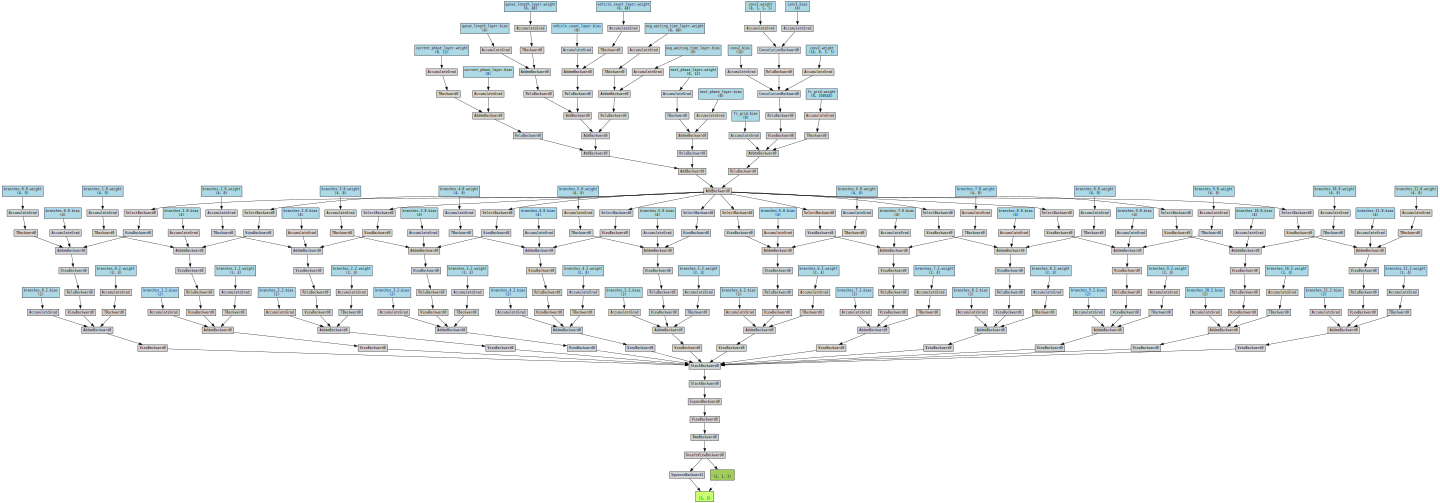

In [9]:
sumoBinary = "/usr/bin/sumo"
sumoCmd = [sumoBinary, "-c", "/usr/share/sumo/tools/game/cross_demo.sumocfg"]

# Start the SUMO simulation with TraCI
traci.start(sumoCmd)
# Get the sample current state
sample_current_state = get_current_state()
# End SUMO simulation
traci.close()


use_pretrained = False
dqn_model = DQNModel(len(sample_current_state["queue_length"]), len(sample_current_state["vehicle_count"]), len(sample_current_state["avg_waiting_time"]))
if use_pretrained:
    dqn_model = torch.load("/kaggle/input/experiment1-phase2-model/DQNModel.pth")
    

dqn_model.eval()
pred = dqn_model([sample_current_state])
dqn_model_arch = make_dot(pred, params=dict(list(dqn_model.named_parameters())))
resize_graph(dqn_model_arch, size_per_element=0.0001, min_size=20)
dqn_model_arch.render("DQNModel-Architecture", format="svg")
dqn_model_arch

In [10]:
print("Number of trainable parameters:", sum(p.numel() for p in dqn_model.parameters() if p.requires_grad))

Number of trainable parameters: 1209720


## Implementing the Deep Q-Learning with Experience Replay algorithm

In [11]:
memory = deque(maxlen=8000)
gamma = 0.95  # discount rate
epsilon = 1.0  # exploration rate
epsilon_min = 0.001
epsilon_decay = 0.999
batch_size = 1536
train_start = 4000 # Initial steps to fill up the replay buffer


def remember(state, action, reward, next_state, done):
    global memory
    global train_start
    global epsilon
    global epsilon_min
    global epsilon_decay
    memory.append((state, action, reward, next_state, done))
    if len(memory) > train_start:
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

def act(state, model):
    global epsilon
    if np.random.random() <= epsilon:
        return random.randrange(2)
    else:
        return torch.argmax(model([state])).item()

def replay(model, optimizer, loss_function):
    global memory
    global batch_size
    global gamma
    # Randomly sample minibatch from the memory
    minibatch = random.sample(memory, min(len(memory), batch_size))

    state = []
    next_state = []
    action, reward, done = [], [], []

    for i in range(batch_size):
        state.append(minibatch[i][0])
        action.append(minibatch[i][1])
        reward.append(minibatch[i][2])
        next_state.append(minibatch[i][3])
        done.append(minibatch[i][4])

    # do batch prediction for parallel computation
    target = model(state)
    target_next = model(next_state)

    for i in range(batch_size):
        # correction on the Q value for the action used
        if done[i]:
            target[i][action[i]] = reward[i]
        else:
            target[i][action[i]] = reward[i] + gamma * (torch.max(target_next[i]))

    # Train the Neural Network with batches
    pred = model(state)
    loss = loss_function(pred, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Training

In [12]:
dqn_model.train()

learning_rate = 0.001
optimizer = optim.Adam(dqn_model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

num_train_episodes = 20
num_train_episode_steps = 5000
offline_training_steps = 3000 # Offline training after train_start. After this online training will start
train_every = 50 # Training the model at intervals of "train_every" episode steps

# Path to SUMO binary
sumoBinary = "/usr/bin/sumo"
sumoCmd = [sumoBinary, "-c", "/usr/share/sumo/tools/game/cross_demo.sumocfg"]

# We would follow the fixed timing approach before train_start and during the offline training
fixed_phase_durations_sec = {
    0:  3,
    1:  1,
    2:  30,
    3:  3,
    4:  1,
    5:  30,
    6:  3,
    7:  1,
    8:  30,
    9:  3,
    10: 1,
    11: 30
}

total_train_episode_steps = 0
for episode in range(num_train_episodes):
    
    # Start the SUMO simulation with TraCI
    traci.start(sumoCmd)

    # Keeping track of the simulation time at phase changes
    simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000

    
    # Loop to interact with the SUMO simulation
    episode_steps = 0
    cumulative_reward = 0
    done = False
    while episode_steps < num_train_episode_steps:
        
        # Get the current state
        current_state = get_current_state()

        # Dictionary to store vehicle entry times
        vehicle_start_times = {}

        # Get current simulation time (in seconds)
        current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s

        # Compute vehicle start times
        vehicle_ids = traci.vehicle.getIDList()
        for veh_id in vehicle_ids:
            # Update the start time (to be tracked from last action taken)
            vehicle_start_times[veh_id] = current_time
            
            

        # Action selection
        traffic_light_ids = traci.trafficlight.getIDList()
        action = ""
        if total_train_episode_steps < (train_start + offline_training_steps): # Use fixed timing approach
            action = 0
            if (current_time - simulation_time_at_phase_change) >= fixed_phase_durations_sec[current_state["current_phase"][traffic_light_ids[0]]]:
                action = 1
        else: # Use the RL agent's predicted actions... beginning of online training 
            action = act(current_state, dqn_model)
        
        # Advance simulation by one step
        traci.simulationStep()

        # Set traffic light phase according to action chosen
        if action == 1:
            traci.trafficlight.setPhase(traffic_light_ids[0], (current_state["current_phase"][traffic_light_ids[0]] + 1) % 12)
        else:
            traci.trafficlight.setPhase(traffic_light_ids[0], current_state["current_phase"][traffic_light_ids[0]])
        
        

        # Get the new state after action is taken
        next_state = get_current_state()

        # Get current simulation time (in seconds)
        current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s

        # List to store travel times for vehicles that have exited the frame
        vehicle_travel_times = []

        # Track vehicles that have exited
        arrived_vehicle_ids = traci.simulation.getArrivedIDList()
        for veh_id in arrived_vehicle_ids:
            if veh_id in vehicle_start_times:
                # Calculate travel time
                start_time = vehicle_start_times[veh_id]
                travel_time = current_time - start_time

                # Store the travel time
                vehicle_travel_times.append(travel_time)

                # Remove the vehicle from the tracking dictionary
                del vehicle_start_times[veh_id]
                
                

        # Get the reward
        reward, reward_factors = compute_reward(current_state, next_state, simulation_time_at_phase_change, vehicle_travel_times)
        
        

        # Update simulation_time_at_phase_change if a phase change has occured
        traffic_light_changes = sum(
            1 if next_state["current_phase"][tl] != current_state["current_phase"][tl] else 0
            for tl in traci.trafficlight.getIDList()
        )
        phase_change = 0
        if traffic_light_changes > 0:
            phase_change = 1
        if phase_change == 1:
            simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
            
            
            
        # Calculate cumulative reward, append data to replay buffer etc...
        cumulative_reward += reward
                    
        if episode_steps == num_train_episode_steps - 1:
            done = True

        remember(current_state, action, reward, next_state, done)

        if done:                   
            print("episode: {}/{}, cumulative_reward: {}, epsilon: {:.2}".format(episode+1, num_train_episodes, cumulative_reward, epsilon))
            
        if (total_train_episode_steps >= train_start) and (episode_steps % train_every == 0):
            replay(dqn_model, optimizer, loss_function)
            torch.save(dqn_model, "DQNModel.pth") # Saving the dqn_model
        
        episode_steps += 1
        total_train_episode_steps += 1
        
    # End SUMO simulation
    traci.close()

## Loading the trained DQNModel for evaluation

In [13]:
loaded_dqn_model = torch.load("DQNModel.pth")

## Evaluation

### Extracting the data for eval episodes

We are going to average all our metrics over the eval episodes

In [14]:
loaded_dqn_model.eval()

num_eval_episodes = 5
num_eval_episode_steps = 5000

# Path to SUMO binary
sumoBinary = "/usr/bin/sumo"
sumoCmd = [sumoBinary, "-c", "/usr/share/sumo/tools/game/cross_demo.sumocfg"]

eval_data = []


for episode in range(num_eval_episodes):
    eval_data.append([])
    
    # Start the SUMO simulation with TraCI
    traci.start(sumoCmd)

    # Keeping track of the simulation time at phase changes
    simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000

    
    # Loop to interact with the SUMO simulation
    episode_steps = 0
    while episode_steps < num_eval_episode_steps:
        
        # Get the current state
        current_state = get_current_state()

        # Dictionary to store vehicle entry times
        vehicle_start_times = {}

        # Get current simulation time (in seconds)
        current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s

        # Compute vehicle start times
        vehicle_ids = traci.vehicle.getIDList()
        for veh_id in vehicle_ids:
            # Update the start time (to be tracked from last action taken)
            vehicle_start_times[veh_id] = current_time
            
            

        # Action selection based on the RL agent
        traffic_light_ids = traci.trafficlight.getIDList()
        action = torch.argmax(loaded_dqn_model([current_state])).item()
        
        # Advance simulation by one step
        traci.simulationStep()

        # Set traffic light phase according to action chosen
        if action == 1:
            traci.trafficlight.setPhase(traffic_light_ids[0], (current_state["current_phase"][traffic_light_ids[0]] + 1) % 12)
        else:
            traci.trafficlight.setPhase(traffic_light_ids[0], current_state["current_phase"][traffic_light_ids[0]])
        
        

        # Get the new state after action is taken
        next_state = get_current_state()

        # Get current simulation time (in seconds)
        current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s

        # List to store travel times for vehicles that have exited the frame
        vehicle_travel_times = []

        # Track vehicles that have exited
        arrived_vehicle_ids = traci.simulation.getArrivedIDList()
        for veh_id in arrived_vehicle_ids:
            if veh_id in vehicle_start_times:
                # Calculate travel time
                start_time = vehicle_start_times[veh_id]
                travel_time = current_time - start_time

                # Store the travel time
                vehicle_travel_times.append(travel_time)

                # Remove the vehicle from the tracking dictionary
                del vehicle_start_times[veh_id]
                
                

        # Get the reward
        reward, reward_factors = compute_reward(current_state, next_state, simulation_time_at_phase_change, vehicle_travel_times)
        eval_data[-1].append((reward, reward_factors))
        
        

        # Update simulation_time_at_phase_change if a phase change has occured
        traffic_light_changes = sum(
            1 if next_state["current_phase"][tl] != current_state["current_phase"][tl] else 0
            for tl in traci.trafficlight.getIDList()
        )
        phase_change = 0
        if traffic_light_changes > 0:
            phase_change = 1
        if phase_change == 1:
            simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
            
        
        episode_steps += 1
        
    # End SUMO simulation
    traci.close()

 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/3303521186.py:20: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_24/3303521186.py:34: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/3303521186.py:63: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/3960940594.py:93: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  1 if ((phase_change == 1) and ((traci.simulation.getCurrentTime()/1000 - simulation_time_at_phase_change) < min_phase_duration) and ((current_state["current_phase"][tl] % 3) == 0)) else 0
/tmp/ipykernel_24/3303521186.py

S

Step #14.60

Step #16.80

Step #26.00

Step #28.40

Step #32.60

Step #35.20

Step #43.40

Step #45.40

Step #53.80

Step #59.80

Step #67.40

Step #74.00

Step #78.60

Step #93.80

Step #120.80 (

Step #123.80

Step #127.00

Step #146.60

Step #162.80

Step #164.60

Step #167.00

Step #171.40

Step #211.40

Step #212.60

Step #233.00

Step #238.00

Step #254.40

Step #258.20

Step #271.40

Step #280.40 

Step #301.40

Step #310.40 

Step #338.60 (1

Step #347.00

Step #360.20

Step #373.60

Step #391.40

Step #431.60

Step #441.20

Step #459.20 (

Step #471.80 

Step #482.00

Step #491.00 

Step #509.20

Step #522.80

Step #531.80 

Step #551.60

Step #561.80

Step #588.20

Step #599.00

Step #635.00

Step #647.60

Step #656.60 

Step #672.20

Step #679.40

Step #724.40

Step #740.60

Step #749.00

Step #750.80

Step #751.40

Step #806.60

Step #808.40

Step #855.80

Step #861.80

Step #863.60

Step #894.80

Step #898.20

Step #919.40

Step #921.20

Step #935.00

Step #971.00

Step #975.00

 Retrying in 1 seconds
Loading configuration ... done.


Step #12.20

Step #16.80

Step #26.00

Step #28.40

Step #32.60

Step #43.40

Step #45.40

Step #53.80

Step #57.20

Step #59.80

Step #67.40

Step #71.60

Step #74.00

Step #78.60

Step #87.60 

Step #122.60

Step #123.80

Step #127.00

Step #146.60

Step #154.00

Step #162.80

Step #167.00

Step #169.40

Step #171.40

Step #175.40

Step #211.40

Step #212.60

Step #233.00

Step #247.00 

Step #258.20

Step #267.20 

Step #280.40 

Step #301.40

Step #310.40 

Step #342.80

Step #347.00

Step #360.20

Step #369.20 

Step #391.40

Step #431.60

Step #441.20

Step #462.80

Step #474.20

Step #482.00

Step #491.00 

Step #500.00

Step #522.80

Step #531.80 

Step #551.60

Step #561.80

Step #588.20

Step #590.00

Step #599.00

Step #626.00 (0

Step #644.00 

Step #656.60 

Step #672.20

Step #681.20

Step #724.40

Step #740.60

Step #751.40

Step #806.00

Step #806.60

Step #808.40

Step #810.00

Step #855.00 (1ms

Step #861.80

Step #894.80

Step #898.20

Step #919.40

Step #921.20

Step #930.20 

Step #971.00

Step #975.00

 Retrying in 1 seconds
Loading configuration ... done.


Step #12.20

Step #14.60

Step #26.00

Step #28.40

Step #35.20

Step #45.40

Step #53.80

Step #57.20

Step #59.80

Step #71.60

Step #74.00

Step #93.80

Step #120.80 (

Step #123.80

Step #146.60

Step #154.00

Step #162.80

Step #164.60

Step #167.00

Step #171.40

Step #175.40

Step #202.40 (0

Step #212.60

Step #233.00

Step #238.00

Step #254.40

Step #258.20

Step #271.40

Step #282.80

Step #301.40

Step #311.60

Step #342.80

Step #356.00 

Step #373.60

Step #391.40

Step #431.60

Step #441.20

Step #462.80

Step #474.20

Step #500.00

Step #509.20

Step #518.20 

Step #537.80

Step #551.60

Step #561.80

Step #563.60

Step #581.60 (

Step #588.20

Step #599.00

Step #635.00

Step #647.60

Step #658.20

Step #672.20

Step #681.20

Step #717.20 (0m

Step #733.40 

Step #749.00

Step #751.40

Step #805.40 (1ms 

Step #806.60

Step #808.40

Step #855.80

Step #861.80

Step #863.60

Step #894.80

Step #898.20

Step #916.20 (

Step #919.40

Step #930.20 

Step #971.00

 Retrying in 1 seconds
Loading configuration ... done.


Step #12.20

Step #14.60

Step #16.80

Step #26.00

Step #28.40

Step #32.60

Step #35.20

Step #43.40

Step #53.80

Step #57.20

Step #59.80

Step #71.60

Step #74.00

Step #87.60 

Step #120.80 (

Step #123.80

Step #146.60

Step #154.00

Step #164.60

Step #167.00

Step #169.40

Step #171.40

Step #175.40

Step #202.40 (1

Step #212.60

Step #233.00

Step #254.40

Step #267.20 

Step #282.80

Step #301.40

Step #311.60

Step #338.60 (1

Step #347.00

Step #360.20

Step #369.20 

Step #391.40

Step #431.60

Step #441.20

Step #462.80

Step #474.20

Step #491.00 

Step #500.00

Step #518.20 

Step #537.80

Step #546.80 

Step #561.80

Step #563.60

Step #588.20

Step #599.00

Step #626.00 (0

Step #647.60

Step #658.20

Step #672.20

Step #679.40

Step #681.20

Step #717.20 (0m

Step #733.40 

Step #740.60

Step #751.40

Step #806.00

Step #806.60

Step #808.40

Step #855.00 (1ms

Step #861.80

Step #894.80

Step #919.40

Step #921.20

Step #935.00

Step #971.00

 Retrying in 1 seconds
Loading configuration ... done.


Step #12.20

Step #14.60

Step #16.80

Step #26.00

Step #28.40

Step #32.60

Step #43.40

Step #53.80

Step #59.80

Step #71.60

Step #78.60

Step #93.80

Step #120.80 (

Step #123.80

Step #127.00

Step #146.60

Step #154.00

Step #162.80

Step #167.00

Step #169.40

Step #171.40

Step #175.40

Step #211.40

Step #212.60

Step #233.00

Step #238.00

Step #254.40

Step #258.20

Step #267.20 

Step #280.40 

Step #301.40

Step #310.40 

Step #342.80

Step #347.00

Step #359.60

Step #360.20

Step #373.60

Step #391.40

Step #431.60

Step #441.20

Step #462.20

Step #462.80

Step #471.80 

Step #474.20

Step #500.00

Step #509.20

Step #522.80

Step #537.80

Step #546.80 

Step #561.80

Step #563.60

Step #588.20

Step #590.00

Step #635.00

Step #647.60

Step #656.60 

Step #672.20

Step #681.20

Step #724.40

Step #733.40 

Step #749.00

Step #751.40

Step #806.00

Step #808.40

Step #855.00 (1ms

Step #861.80

Step #863.60

Step #894.80

Step #898.20

Step #916.20 (

Step #921.20

Step #930.20 

Step #971.00

### Visualising the evaluation data obtained 

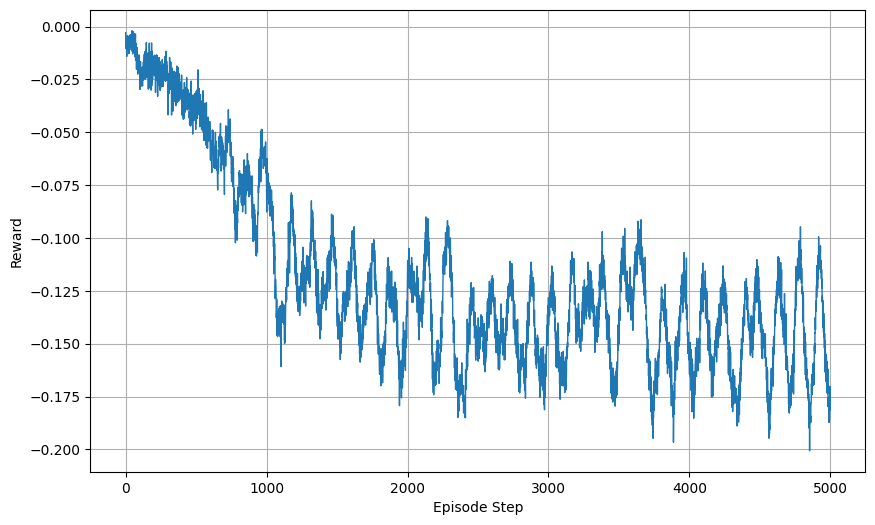

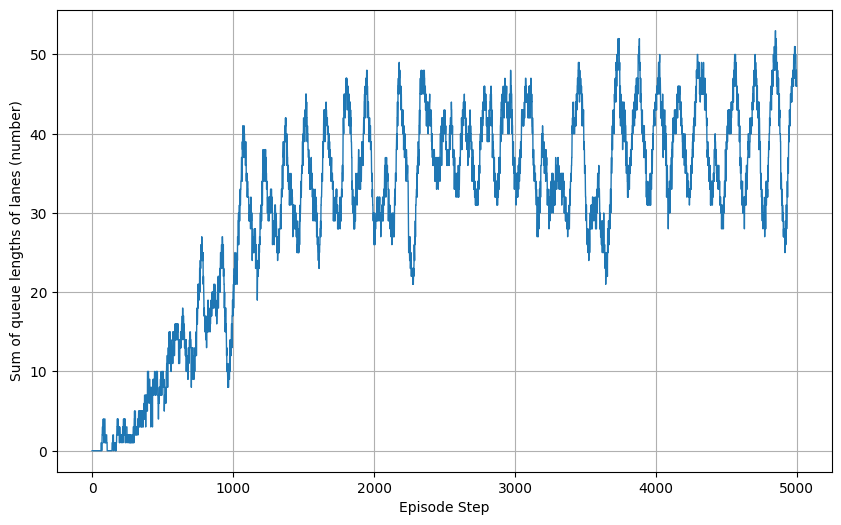

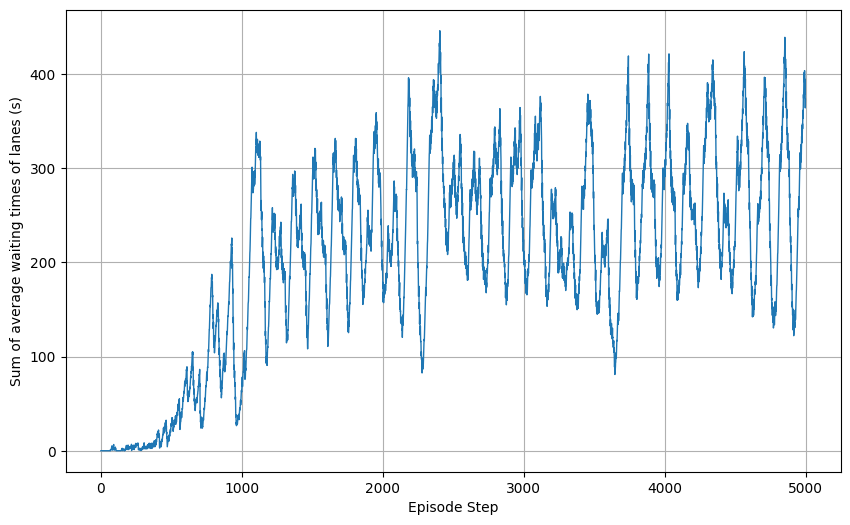

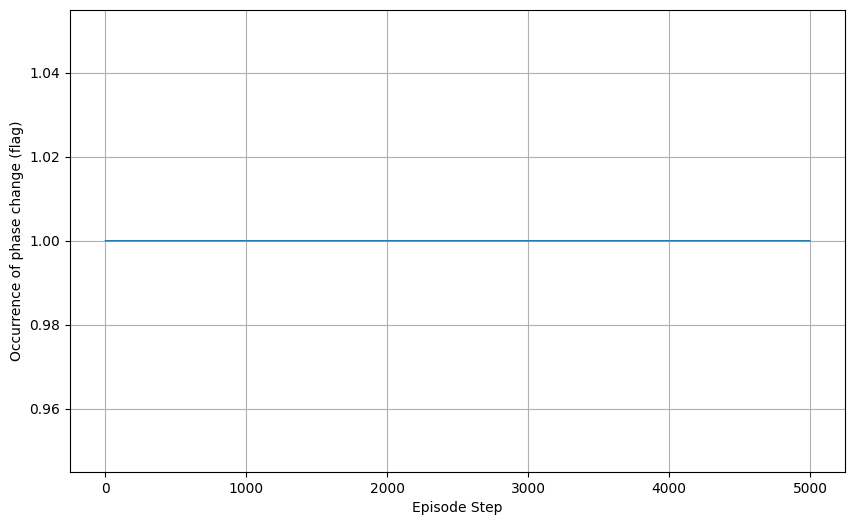

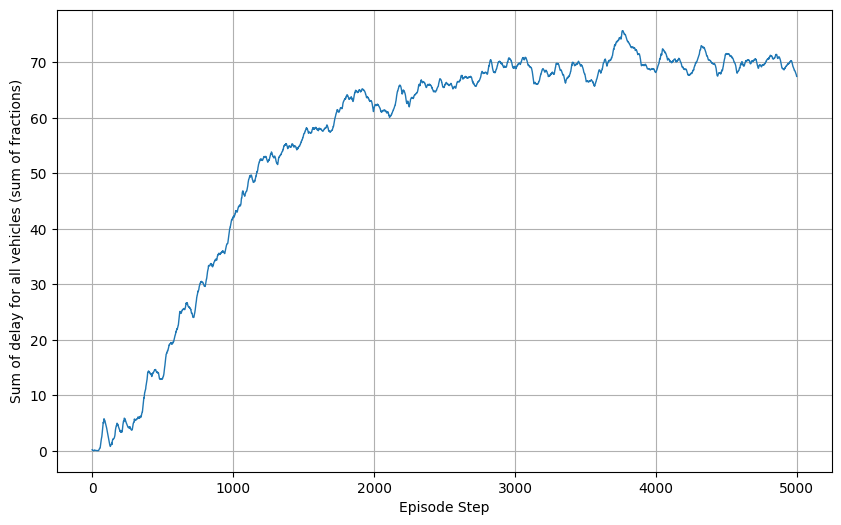

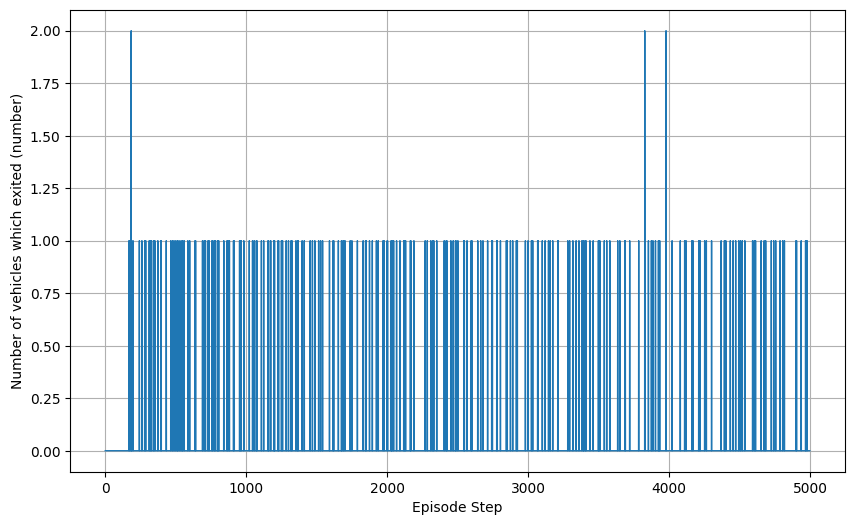

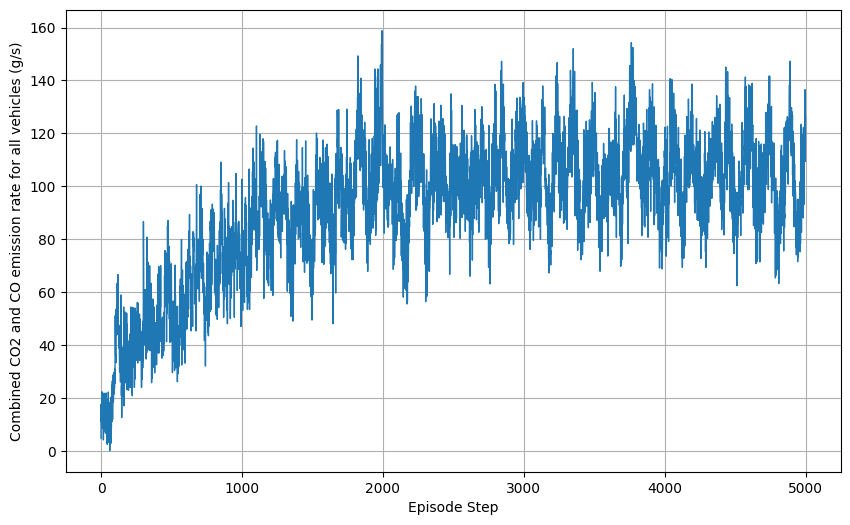

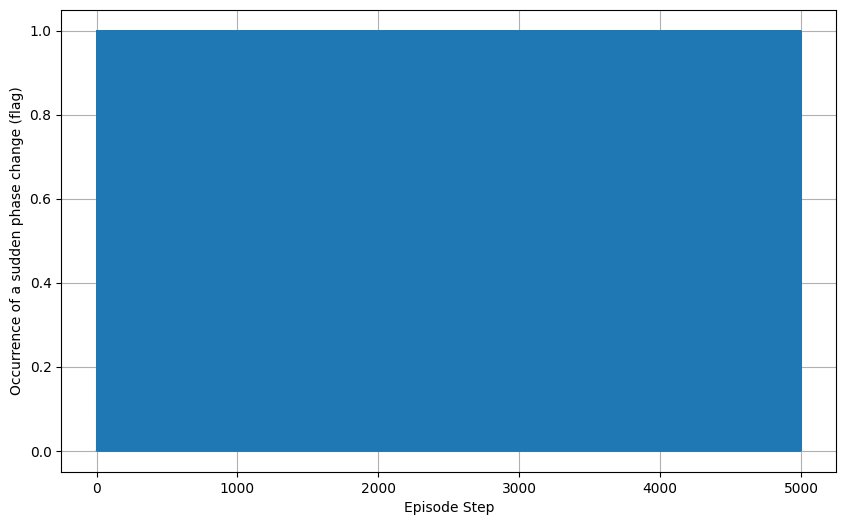

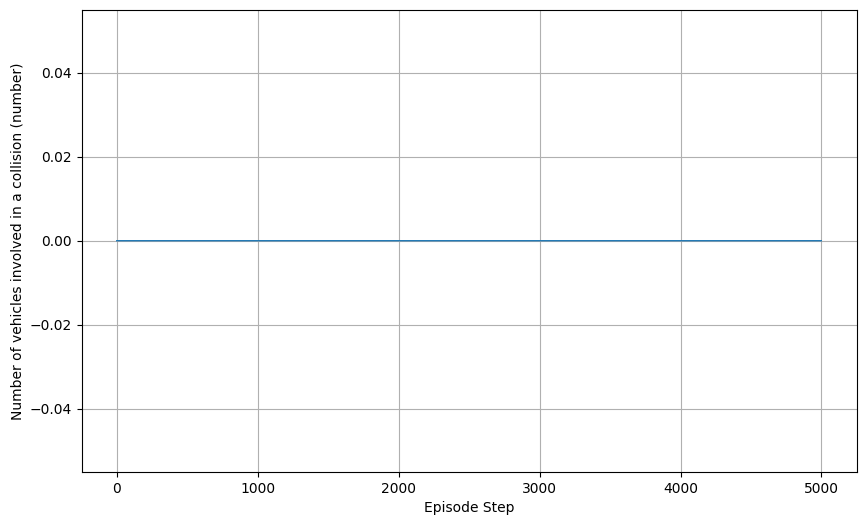

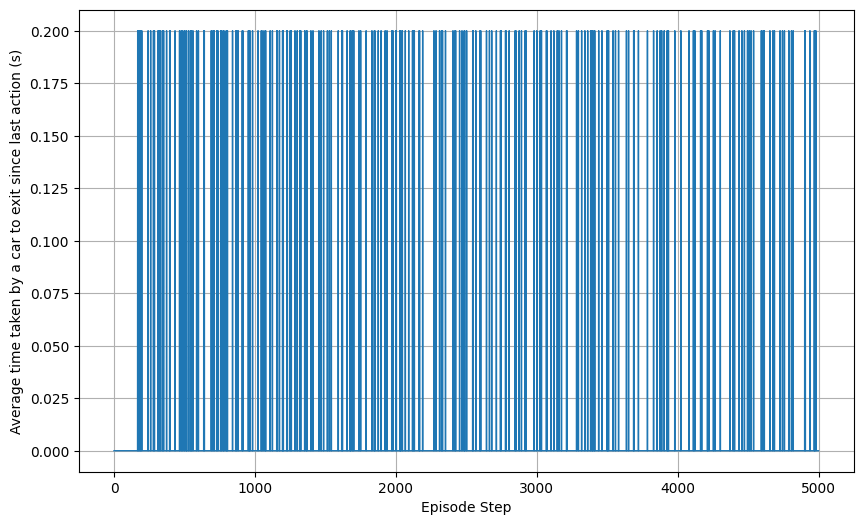

In [15]:
# Reward factor naming dictionary
naming_dict = {
    "queue_length": "Sum of queue lengths of lanes (number)",
    "avg_waiting_time": "Sum of average waiting times of lanes (s)",
    "phase_change": "Occurrence of phase change (flag)",
    "total_delay": "Sum of delay for all vehicles (sum of fractions)",
    "vehicles_passed": "Number of vehicles which exited (number)",
    "total_emissions": "Combined CO2 and CO emission rate for all vehicles (g/s)",
    "sudden_phase_change": "Occurrence of a sudden phase change (flag)",
    "num_collided_vehicles": "Number of vehicles involved in a collision (number)",
    "average_travel_time": "Average time taken by a car to exit since last action (s)"
}

# Number of steps for each episode
num_steps = len(eval_data[0])

# Initialize lists to store summed values for each step
reward_sums = []
reward_factor_sums = {
    "queue_length": [],
    "avg_waiting_time": [],
    "phase_change": [],
    "total_delay": [],
    "vehicles_passed": [],
    "total_emissions": [],
    "sudden_phase_change": [],
    "num_collided_vehicles": [],
    "average_travel_time": []
}
for i in range(num_steps):
    reward_sums.append(0)
    for key in reward_factor_sums:
        reward_factor_sums[key].append(0)

# Accumulate rewards and reward factors for each step across all episodes
for episode in eval_data:
    for step_index, (reward, reward_factors) in enumerate(episode):
        reward_sums[step_index] += reward
        
        for key in reward_factor_sums:
            reward_factor_sums[key][step_index] += reward_factors[key]

# Number of episodes
num_episodes = len(eval_data)

# Calculate the average for each step
average_rewards = [reward_sums[i] / num_episodes for i in range(num_steps)]

average_reward_factors = {
    key: [reward_factor_sums[key][i] / num_episodes for i in range(num_steps)]
    for key in reward_factor_sums
}

# Plotting
steps = np.arange(num_steps)  # X-axis for plotting

line_thickness = 1

# Plot average reward
plt.figure(figsize=(10, 6))
plt.plot(steps, average_rewards, linestyle='-', linewidth=line_thickness)
plt.xlabel("Episode Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Plot reward factors
for key, values in average_reward_factors.items():
    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, linestyle='-', linewidth=line_thickness)
    plt.xlabel("Episode Step")
    plt.ylabel(naming_dict[key])
    plt.grid(True)
    plt.show()

In [16]:
# Function to compute min, max, mean and sum
def compute_stats(values):
    min_value = min(values)
    max_value = max(values)
    mean_value = np.mean(values)
    cumulative_value = sum(values)
    return min_value, max_value, mean_value, cumulative_value

# Compute and print the stats for average rewards
reward_min, reward_max, reward_mean, reward_cumulative = compute_stats(average_rewards)
print("Reward - Min:", reward_min)
print("Reward - Max:", reward_max)
print("Reward - Mean:", reward_mean)
print("Reward - Cumulative:", reward_cumulative)
print("")

# Compute and print the stats for each reward factor
for key, values in average_reward_factors.items():
    factor_min, factor_max, factor_mean, factor_cumulative = compute_stats(values)
    print(f"{naming_dict[key]} - Min:", factor_min)
    print(f"{naming_dict[key]} - Max:", factor_max)
    print(f"{naming_dict[key]} - Mean:", factor_mean)
    print(f"{naming_dict[key]} - Cumulative:", factor_cumulative)
    print("")

Reward - Min: -0.20060726050552052
Reward - Max: -0.0019935526707901136
Reward - Mean: -0.11924628340894321
Reward - Cumulative: -596.2314170447148

Sum of queue lengths of lanes (number) - Min: 0.0
Sum of queue lengths of lanes (number) - Max: 53.0
Sum of queue lengths of lanes (number) - Mean: 31.425
Sum of queue lengths of lanes (number) - Cumulative: 157125.0

Sum of average waiting times of lanes (s) - Min: 0.0
Sum of average waiting times of lanes (s) - Max: 446.2
Sum of average waiting times of lanes (s) - Mean: 207.82344000000003
Sum of average waiting times of lanes (s) - Cumulative: 1039117.1999999984

Occurrence of phase change (flag) - Min: 1.0
Occurrence of phase change (flag) - Max: 1.0
Occurrence of phase change (flag) - Mean: 1.0
Occurrence of phase change (flag) - Cumulative: 5000.0

Sum of delay for all vehicles (sum of fractions) - Min: 0.030940502448194684
Sum of delay for all vehicles (sum of fractions) - Max: 75.6740352266659
Sum of delay for all vehicles (sum of 